In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [31]:
import numpy as np
import pandas as pd

In [32]:
import datetime as dt

#  Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [34]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

#  Exploratory Climate Analysis

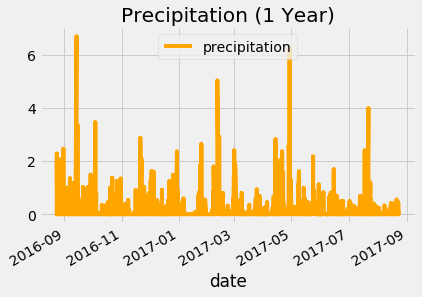

In [50]:
 # Design a query to retrieve the last 12 months of precipitation data and plot the results
perc_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
perc_date = perc_date[0]
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(perc_date, "%Y-%m-%d") - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df .plot(title="Precipitation (1 Year)", color = "Orange")
plt.legend(loc='upper center')
plt.savefig("Images/1_Year_Precipitation.png")
plt.show()

In [51]:
 # Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {available_stations} ")

Stations Available: 9 


In [53]:
 # What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
most_active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Finding most active station 
active_stations = most_active_stations[0][0]
print(f"Most Active Station: {active_stations}")

Most Active Station: USC00519281


In [61]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == active_stations).all()
print(f"Active Station Temperatures")
print(f"Low: {active_temp[0][0]} High: {active_temp[0][1]} Average: {round(active_temp[0][2], 1)}")

Active Station Temperatures
Low: 54 High: 85 Average: 71.7


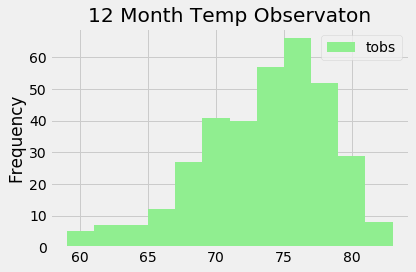

In [73]:
# Choose the station with the highest number of temperature observations.
high_temp_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
high_temp_station= high_temp_station[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observation = session.query( Measurement.tobs).filter(Measurement.date >= last_year).filter(Measurement.station == high_temp_station).all()
temperature_observation = pd.DataFrame(temperature_observation, columns=['tobs'])

temperature_observation.plot.hist(bins=12, color="lightgreen", title="12 Month Temp Observaton")
plt.tight_layout()
plt.savefig("Images/Temperature_Observation.png")
plt.show()

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62, 69.57142857142857, 74)]


In [75]:
 # Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-07-01','2017-07-14')
trip_temps

[(69, 78.11627906976744, 87)]

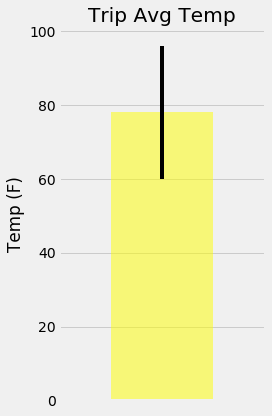

In [79]:
# Created a dataframe with tmin, tavg, and tmax values
trip_temps_df = pd.DataFrame(trip_temps, columns=['tmin', 'tavg', 'tmax'])

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df.plot.bar(y='tavg', yerr=(trip_temps_df['tmax'] - trip_temps_df['tmin']), title='Trip Avg Temp', color='yellow', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/AvgTripTemp.png")
plt.show()

In [80]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-01','2017-07-14'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


# Optional Challenge Assignment

In [84]:
 # Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62, 69.15384615384616, 77)]

In [88]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
day_1 = '2017-07-01'
last_day ='2017-07-14'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= day_1).filter(Measurement.date <= last_day).group_by(Measurement.date).all()
vacation_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings
vacation_dates_strip= [x[5:] for x in vacation_dates]
start_month_day = vacation_dates_strip[0]
end_month_day = vacation_dates_strip[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregated Daily Normals for 07-01 to 07-14")
daily_normals

Aggregated Daily Normals for 07-01 to 07-14


[(67, 74.77777777777777, 81),
 (68, 75.40384615384616, 82),
 (68, 75.32075471698113, 87),
 (70, 76.57142857142857, 81),
 (66, 75.0, 81),
 (69, 75.0, 81),
 (69, 74.91071428571429, 82),
 (69, 76.08333333333333, 83),
 (68, 76.19298245614036, 83),
 (68, 75.62068965517241, 82),
 (70, 75.78947368421052, 81),
 (67, 75.96491228070175, 82),
 (69, 76.1896551724138, 81),
 (61, 76.2280701754386, 82)]

In [90]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

daily_normals_df['date']= vacation_dates

daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-01,67,74.777778,81
2017-07-02,68,75.403846,82
2017-07-03,68,75.320755,87
2017-07-04,70,76.571429,81
2017-07-05,66,75.000000,81
2017-07-06,69,75.000000,81
2017-07-07,69,74.910714,82
2017-07-08,69,76.083333,83
2017-07-09,68,76.192982,83


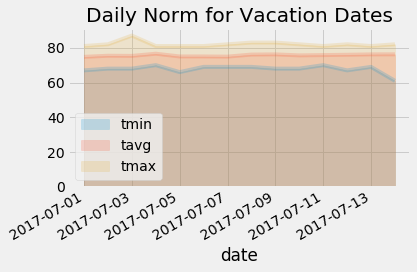

In [93]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Norm for Vacation Dates")
plt.tight_layout()
plt.savefig("Images/DailyNorm.png")
plt.show()